In [27]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.patches as patches
import random

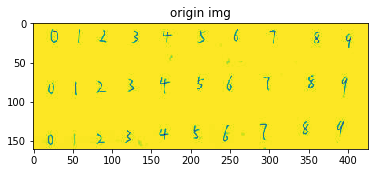

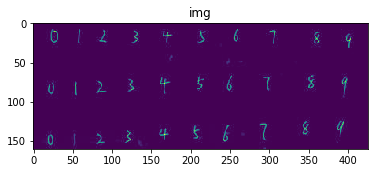

(160, 426)


In [12]:
img = cv2.imread('f:/hand_writing/6.jpg', cv2.IMREAD_GRAYSCALE)
plt.title('origin img')
plt.imshow(img)
plt.show()
img = 255 - img
img = (img - np.min(img)) / (np.max(img) - np.min(img))
plt.title('img')
plt.imshow(img)
plt.show()
print(img.shape)

In [19]:
# coding: utf-8

from collections import OrderedDict


class Region(object):
    """
    This class is used to describe a rectangle.
    It has five vars include x, y, width, height and sub_regions,
        the sub_regions is also a Region object.
    """

    def __init__(self, x=0, y=0, width=0, height=0, img=None):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.sub_regions = OrderedDict()
        self.img = img
        self.recognition = None
        self.result = None
        # print 'Class has been initialized', vars(self)

    def get_x(self):
        return self.x

    def get_y(self):
        return self.y

    def get_width(self):
        return self.width

    def get_height(self):
        return self.height

    def set_x(self, x):
        self.x = x

    def set_y(self, y):
        self.y = y

    def set_width(self, width):
        self.width = width

    def set_height(self, height):
        self.width = height

    def get_sub_regions(self):
        return self.sub_regions

    def add_sub_region(self, region):
        self.sub_regions.append(region)

    def get_img(self):
        return self.img

    def set_img(self, img):
        self.img = img

    def get_recognition(self):
        return self.recognition

    def set_recognition(self, reco_str):
        self.recognition = reco_str

    def get_result(self):
        return self.result

    def set_result(self, result):
        self.result = result


# test
if __name__ == '__main__':
    r = Region(10, 10, 2, 2)


In [15]:
def cut(img, row_eps, col_eps, display=False):
    """
    cut a image
    :param img:
    :param row_eps:
    :param col_eps:
    :param display:
    :return:
    """
    question_areas = project_cut(img, row_eps, col_eps)
    # show_all_regions(img, question_areas, layer=1)
    for k, v in question_areas.items():
        region_arr = region2ndarray(img, v)

        number_areas = project_cut(
            region_arr, 0, 0, resize=True, display=display)

        v.sub_regions = number_areas

    return question_areas


def save_region_as_jpg(fname, img, region, diastolic=True):
    """

    :param fname:
    :param img:
    :param region:
    :param diastolic:
    :return:
    """
    sub_img = get_region_img(img, region)

    if diastolic:
        cv2.imwrite(fname, sub_img * 255)
    else:
        cv2.imwrite(fname, sub_img)

    cv2.destroyAllWindows()

In [16]:
def read_img(file_name, color_inv_norm=True):
    """
    read a image from local file system
    :param file_name:
    :param color_inv_norm:
    :return:
    """
    img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)

    if color_inv_norm:
        img = 255 - img

        # img = remove_back(img, np.ones((5, 5), np.uint8))

        img[img < 20] = 0
        img = img / 255.0
    else:
        img[img < 50] = 0
        img = img / 255.0

    return img


def remove_back(img, kernel):
    """

    :param img:
    :param kernel:
    :return:
    """
    plt.imshow(img)
    plt.show()

    mask = cv2.adaptiveThreshold(img, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 7)
    plt.imshow(mask)
    plt.show()

    kernel = np.ones((5, 5), np.uint8)

    img_mask = img * (1 - mask)

    img_mask = cv2.morphologyEx(img_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    img_mask = cv2.morphologyEx(img_mask, cv2.MORPH_OPEN, kernel, iterations=1)

    img_mask[img_mask > 0] = 1
    img[img < 100] = 0
    img = img * img_mask
    img = img / 255.0

    return img


def region2ndarray(img, region):
    """
    convert a region of img to ndarray
    :param img:
    :param region:
    :return:
    """
    array = img[region.get_y(): region.get_y() + region.get_height(),
                region.get_x(): region.get_x() + region.get_width()]
    return array


def get_hist(img, axis=0):
    """
    return the hist of img with axis
    :param img:
    :param axis:
    :return:
    """
    return np.sum(img, axis=axis)


def get_region_img(img, region):
    """

    :param img:
    :param region:
    :return:
    """
    return img[
           region.get_y(): region.get_y() + region.get_height(),
           region.get_x(): region.get_x() + region.get_width()]


def get_resize_padding_img(img, size=None, padding=None):
    """

    :param img:
    :param size:
    :param padding:
    :return:
    """
    if size and padding:
        sub_img = cv2.resize(img, size)
        sub_img = np.pad(sub_img, padding, mode='constant')
        sub_img = np.pad(sub_img, ((3,), (3,)), mode='constant')
    else:
        sub_img = cv2.resize(img, (28, 28))
    return sub_img


def show_all_regions(img, regions, layer=0):
    """
    show all question regions and number regions with matplotlib
    :param img:
    :param regions:
    :param layer:
    :return:
    """
    plt.figure(0)
    plt.imshow(img, cmap='gray')
    cu = plt.gca()

    for i, question_region in regions.items():
        if layer in [0, 1]:
            cu.add_patch(patches.Rectangle(
                (question_region.get_x(), question_region.get_y()),
                question_region.get_width(), question_region.get_height(),
                linewidth=2, edgecolor='c', facecolor='none'
            ))
        if layer in [0, 2]:
            for j, number_region in question_region.get_sub_regions().items():
                cu.add_patch(patches.Rectangle(
                    (question_region.get_x() + number_region.get_x(),
                     question_region.get_y() + number_region.get_y()),
                    number_region.get_width(), number_region.get_height(),
                    linewidth=1, edgecolor='y', facecolor='none'
                ))
    plt.show()


def save_all_regions(regions, dir_name, layer=0):
    """
    save regions as image
    :param regions:
    :param dir_name:
    :param layer:
    :return:
    """
    for i, question_region in regions.items():
        if layer in [0, 1]:
            cv2.imwrite('%s/%s.jpg' % (dir_name[0], random.randint(1000, 9999)), question_region.get_img() * 255.0)
            cv2.destroyAllWindows()
        if layer in [0, 2]:
            for j, number_region in question_region.get_sub_regions().items():
                cv2.imwrite('%s/%s.jpg' % (dir_name[1], random.randint(1000, 9999)), number_region.get_img() * 255.0)
                cv2.destroyAllWindows()


In [20]:
def get_areas(proj_list, epsilon=0):
    """
    cut the image with the histgram
    :param proj_list: histgram
    :param epsilon: gap length
    :return: the divided areas
    """
    area_list = []
    s = -1
    eps = 0
    for i in range(len(proj_list)):
        if not proj_list[i] == 0 and s == -1:
            s = i
        if not proj_list[i] == 0:
            eps = 0
        if proj_list[i] == 0 and not s == -1:
            e = i
            if eps >= epsilon or i == len(proj_list) - 1:
                area_list.append((s, e - eps))
                s = -1
                eps = 0
            else:
                eps += 1
        if i == len(proj_list) - 1 and not proj_list[i] == 0:
            area_list.append((s, i))
    return area_list


def get_non0_index_scope(l):
    """

    :param l:
    :return:
    """
    if l[0]:
        start = 0
    else:
        start = l.index(True)
    l.reverse()
    if l[0]:
        end = 0
    else:
        end = l.index(True)
    end = len(l) - end
    return start, end


def get_min_content_area(img):
    """

    :param img:
    :return:
    """
    col_proj = (np.sum(img, axis=0) != 0).tolist()
    row_proj = (np.sum(img, axis=1) != 0).tolist()
    col_start, col_end = get_non0_index_scope(col_proj)
    row_start, row_end = get_non0_index_scope(row_proj)

    return row_start, row_end, col_start, col_end


def get_area_dict(img, row_list, col_list, resize=False, display=False):
    """
    obtain the region dict with format {'x0_y0', region}
    :param img:
    :param row_list:
    :param col_list:
    :param resize:
    :param display:
    :return:
    """
    areas = OrderedDict()
    for x0, x1 in row_list:
        for y0, y1 in col_list:
            # x0 x1-x0 y0 y1-y0 are abscissa width ordinate height
            # judge whether the area is only-black
            sub_img = img[y0: y1, x0: x1]
            # 去除较小的区域
            if np.sum(sub_img) <= 6:
                continue

            # 中心化图像
            row_start, row_end, col_start, col_end = get_min_content_area(sub_img)
            sub_img = sub_img[row_start: row_end, col_start: col_end]
            
            # print(row_start, row_end, col_start, col_end)

            if resize:
                # sub_img = cv2.blur(sub_img, (4, 4))
                # if x1 - x0 < y1 - y0:  # 铅直边较长
                #     change_rate = (y1 - y0 - 42) / float((y1 - y0))
                #     changed_width = int((x1 - x0) * (1 - change_rate))

                if col_end - col_start < row_end - row_start:  # 铅直边较长
                    change_rate = (row_end - row_start - 42) / float((row_end - row_start))
                    changed_width = int((col_end - col_start) * (1 - change_rate))

                    if changed_width % 2 == 1:
                        changed_width += 1
                    if changed_width == 0:
                        changed_width = 2
                    pad = (42 - changed_width) / 2
                    padding = ((0,), (int(pad),))

                    # print(y1 - y0, x1 - x0, 1 - change_rate, changed_width, pad)
                    # plt.imshow(sub_img)
                    # plt.show()

                    sub_img = get_resize_padding_img(sub_img, size=(changed_width, 42), padding=padding)

                    # kernel = np.ones((2, 2), np.uint8)
                    # sub_img = cv2.dilate(sub_img, kernel, iterations=1)

                    if display:
                        plt.imshow(sub_img)
                        plt.show()

                else:  # 水平边较长
                    # change_rate = (x1 - x0 - 42) / float((x1 - x0))
                    # changed_height = int((y1 - y0) * (1 - change_rate))

                    change_rate = (col_end - col_start - 42) / float((col_end - col_start))
                    changed_height = int((row_end - row_start) * (1 - change_rate))

                    if changed_height % 2 == 1:
                        changed_height += 1
                    if changed_height == 0:
                        changed_height = 2
                    pad = (42 - changed_height) / 2
                    padding = ((int(pad),), (0,))

                    # print(y1 - y0, x1 - x0, 1 - change_rate, changed_height, pad)
                    # plt.imshow(sub_img)
                    # plt.show()

                    sub_img = get_resize_padding_img(sub_img, size=(42, changed_height), padding=padding)

                    # kernel = np.ones((2, 2), np.uint8)
                    # sub_img = cv2.dilate(sub_img, kernel, iterations=1)

                    if display:
                        plt.imshow(sub_img)
                        plt.show()

            region = Region(x0, y0, x1 - x0, y1 - y0, sub_img)

            areas['%s_%s' % (x0, y0)] = region
    return areas


def project_cut(img, row_eps, col_eps, resize=False, display=False):
    """
    cut img with axis project
    :param img:
    :param row_eps:
    :param col_eps:
    :param resize:
    :param display:
    :return:
    """
    row_proj = np.sum(img, axis=0)
    col_proj = np.sum(img, axis=1)

    row_list = get_areas(row_proj, epsilon=row_eps)  # 横坐标list
    col_list = get_areas(col_proj, epsilon=col_eps)  # 纵坐标list

    # questions area dict
    areas = get_area_dict(
        img, row_list, col_list, resize=resize, display=display)

    return areas


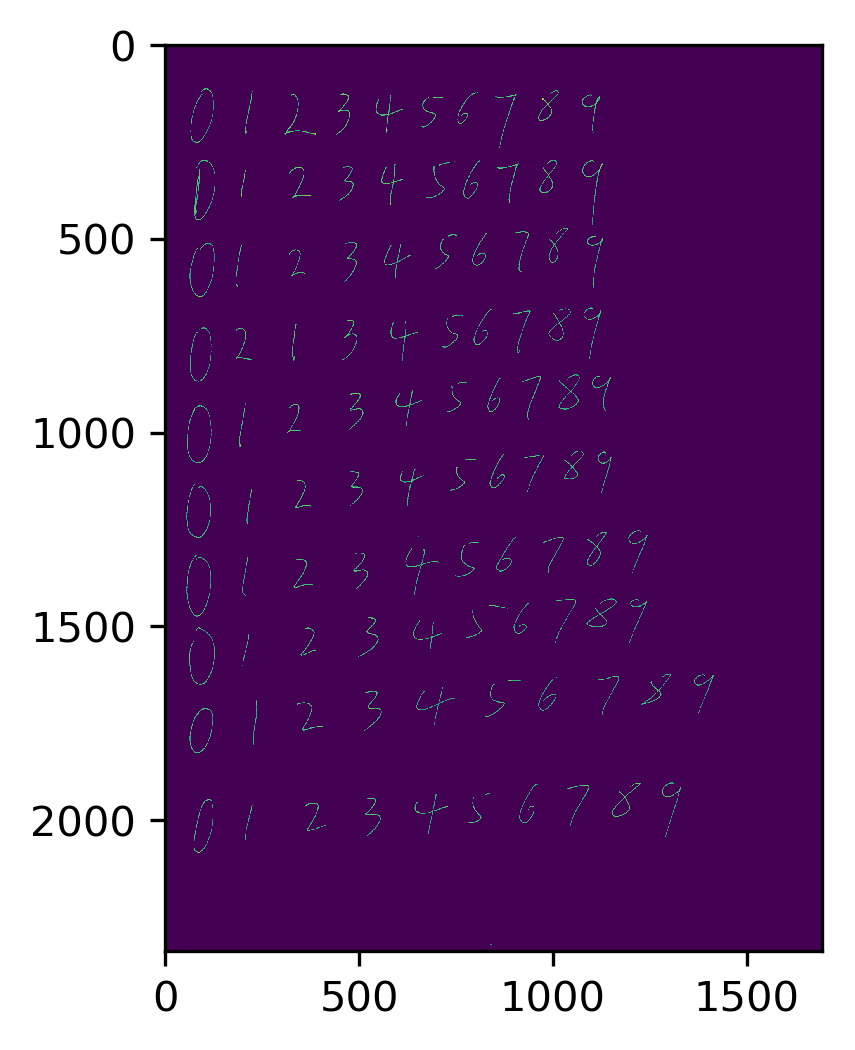

In [44]:
img = cv2.imread('f:/hand_writing/2222.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = 255 - img
img[img < 100] = 0
# img = (img - np.min(img)) / (np.max(img) - np.min(img))
plt.rcParams['figure.dpi'] = 300
plt.imshow(img)

In [45]:
image, contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [46]:
len(contours)

130

In [48]:
# 遍历轮廓
for i in range(len(contours)):
    cnt = contours[i]
    
    # 计算该轮廓的面积
    area = cv2.contourArea(cnt)
    if area < 100:
        continue

    # 轮廓近似，作用很小
    epsilon = 0.001 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)

    # 找到最小有方向矩形
    minrect = cv2.minAreaRect(cnt)
    minbox = cv2.boxPoints(minrect)
    minbox = np.int0(minbox)
    
    # 找到最小无方向矩形
    rect = cv2.boundingRect(cnt)
    box = rect# box是四个点的坐标

    cv2.drawContours(img, [minbox], 0, (0, 255, 0), 2)
    cv2.rectangle(img, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (255, 0, 0), 1)

cv2.namedWindow('img', cv2.WINDOW_NORMAL)
cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()